#AlexNet

In [1]:
!pip install d2l==0.17.5 

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of
        # the output. Here, the number of output channels is much larger than
        # that in LeNet
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        tf.keras.layers.Dense(10)
    ])

In [3]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


In [4]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.328, train acc 0.880, test acc 0.882
713.0 examples/sec on /GPU:0


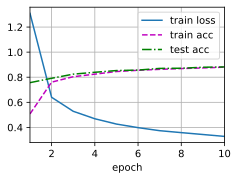

In [5]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#VGG

In [6]:
import tensorflow as tf
from d2l import tensorflow as d2l


def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [7]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [8]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

In [9]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


In [10]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
net = lambda: vgg(small_conv_arch)

loss 0.179, train acc 0.934, test acc 0.922
426.1 examples/sec on /GPU:0


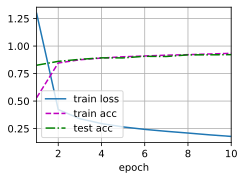

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#Network in Network (NiN)

In [12]:
import tensorflow as tf
from d2l import tensorflow as d2l


def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides,
                               padding=padding, activation='relu'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu')])

In [13]:
def net():
    return tf.keras.models.Sequential([
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1, 1, 10)),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        tf.keras.layers.Flatten(),
        ])

In [14]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


loss 0.333, train acc 0.876, test acc 0.852
469.8 examples/sec on /GPU:0


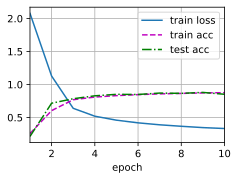

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#GoogLeNet

In [16]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')


    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

In [17]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [18]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [19]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [20]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [21]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [22]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [23]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


loss 0.249, train acc 0.906, test acc 0.886
547.6 examples/sec on /GPU:0


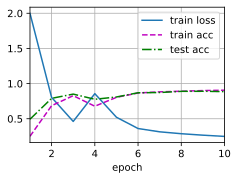

In [24]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#Batch Normalization

In [25]:
import tensorflow as tf
from d2l import tensorflow as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    # Compute reciprocal of square root of the moving variance elementwise
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    # Scale and shift
    inv *= gamma
    Y = X * inv + (beta - moving_mean * inv)
    return Y

In [26]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        weight_shape = [input_shape[-1], ]
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
            initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
            initializer=tf.initializers.zeros, trainable=True)
        # The variables that are not model parameters are initialized to 0
        self.moving_mean = self.add_weight(name='moving_mean',
            shape=weight_shape, initializer=tf.initializers.zeros,
            trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance',
            shape=weight_shape, initializer=tf.initializers.ones,
            trainable=False)
        super(BatchNorm, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        momentum = 0.9
        delta = variable * momentum + value * (1 - momentum)
        return variable.assign(delta)

    @tf.function
    def call(self, inputs, training):
        if training:
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(
                inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            batch_mean = tf.squeeze(batch_mean, axes)
            batch_variance = tf.squeeze(batch_variance, axes)
            mean_update = self.assign_moving_average(
                self.moving_mean, batch_mean)
            variance_update = self.assign_moving_average(
                self.moving_variance, batch_variance)
            self.add_update(mean_update)
            self.add_update(variance_update)
            mean, variance = batch_mean, batch_variance
        else:
            mean, variance = self.moving_mean, self.moving_variance
        output = batch_norm(inputs, moving_mean=mean, moving_var=variance,
            beta=self.beta, gamma=self.gamma, eps=1e-5)
        return output

In [27]:
# Recall that this has to be a function that will be passed to `d2l.train_ch6`
# so that model building or compiling need to be within `strategy.scope()` in
# order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(28, 28, 1)),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(10)]
    )

loss 0.275, train acc 0.898, test acc 0.713
23726.3 examples/sec on /GPU:0


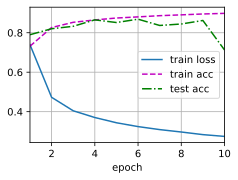

In [28]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#Residual Networks (ResNet)

In [29]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Residual(tf.keras.Model):  #save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [30]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

In [31]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

In [32]:
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [33]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [34]:
b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

In [35]:
# Recall that we define this as a function so we can reuse later and run it
# within `tf.distribute.MirroredStrategy`'s scope to utilize various
# computational resources, e.g. GPUs. Also note that even though we have
# created b1, b2, b3, b4, b5 but we will recreate them inside this function's
# scope instead
def net():
    return tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [36]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 112, 112, 64)
BatchNormalization output shape:	 (1, 112, 112, 64)
Activation output shape:	 (1, 112, 112, 64)
MaxPooling2D output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 28, 28, 128)
ResnetBlock output shape:	 (1, 14, 14, 256)
ResnetBlock output shape:	 (1, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


loss 0.009, train acc 0.998, test acc 0.921
759.7 examples/sec on /GPU:0


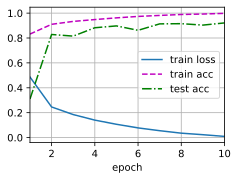

In [37]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu()) 